# Feb ??, 2022 (sliding window FC)

**Motivation**: <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Test

In [2]:
mice = Mice(128)
mice.setup_func_data('led')
df_st = mice.load_stim_times('bold-lite')

In [3]:
key = 'sub-SLC04_ses-2_run-2'
df = df_st.loc[df_st['key'] == key]
stim = df['stim'].values

[<matplotlib.lines.Line2D object at 0x7fb004be9490>]

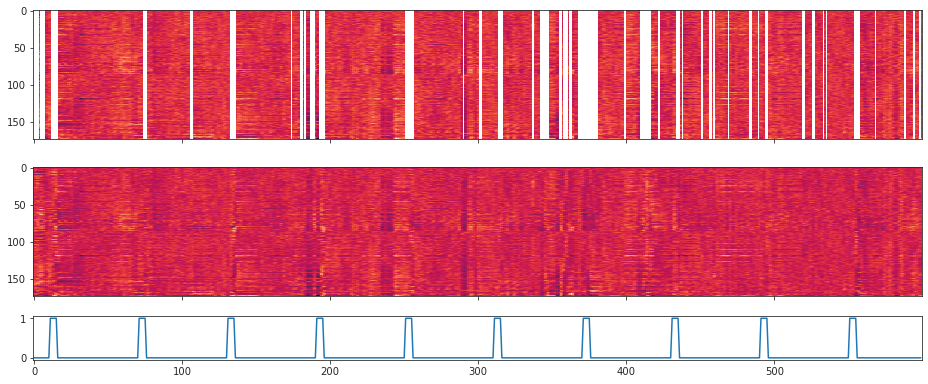

In [4]:
fig, axes = create_figure(3, 1, (13, 5.5), 'all', height_ratios=[1, 1, 0.3])
base = Base(mice, key=key, mode='bold-lite', apply_tmask=True)
axes[0].imshow(base.data, aspect=0.5)

base = Base(mice, key=key, mode='bold-lite', apply_tmask=False)
axes[1].imshow(base.data, aspect=0.5)

axes[2].plot(stim)

## All runs

In [13]:
mice = Mice(128)
mice.setup_func_data('led')
nn = len(mice.node_lookup['ca2'])
df_st = mice.load_stim_times('bold-lite')

In [14]:
duration = 4
fwd = 35
bwd = 15

data_led = np_nans((10, 3, 7, nn, duration * 10))
data_rest = np_nans((10, 3, 7, nn, duration * 10))
for key, (sub, ses, run) in mice.looper.items():
    if key in mice.looper_agg:
        continue
    df = df_st.loc[df_st['key'] == key]
    stim = df['stim'].values
    on = np.where(np.diff(stim) > 0)[0] + 1
    off = np.where(np.diff(stim) < 0)[0] + 1
    if not (len(on) and len(off)):
        continue
    
    base = Base(mice, key=key, mode='bold-lite', apply_tmask=False)

    selected_periods = [range(j - duration, j) for j in off]
    ids_led = []
    for r in selected_periods:
        ids_led.extend(list(r))
    ids_led = np.array(ids_led)
    
    control_periods = [range(j + fwd - duration, j + fwd) for j in off]
    ids_rest = []
    for r in control_periods:
        ids_rest.extend(list(r))
    if max(ids_rest) > base.data.shape[-1]:
        control_periods = [range(j - bwd - duration, j - bwd) for j in on]
        ids_rest = []
        for r in control_periods:
            ids_rest.extend(list(r))
    ids_rest = np.array(ids_rest)
    
    assert max(ids_rest) < base.data.shape[-1]
    assert min(ids_rest) > 0
    
    data_led[sub - 1, ses - 1, run - 1] = base.data[:, ids_led]
    data_rest[sub - 1, ses - 1, run - 1] = base.data[:, ids_rest]

In [15]:
good = []
for i in range(10):
    for j in range(3):
        x = data_led[i, j]
        nans = np.isnan(x).sum(-1).sum(-1)
        good_runs = nans < np.prod(x.shape) / len(nans)
        good.append(list(np.where(good_runs)[0]))
        
        x = data_rest[i, j]
        nans = np.isnan(x).sum(-1).sum(-1)
        good_runs = nans < np.prod(x.shape) / len(nans)
        good.append(list(np.where(good_runs)[0]))

good_union = sorted(set.union(*[set(e) for e in good]))
good_union

[1, 3, 5]

In [16]:
data_led = data_led[..., good_union, :, :]
data_rest = data_rest[..., good_union, :, :]
data_led.shape, data_rest.shape

((10, 3, 3, 174, 40), (10, 3, 3, 174, 40))

In [9]:
adj_led = np_nans((*data_led.shape[:4], nn))
adj_rest = np_nans((*data_rest.shape[:4], nn))

looper = itertools.product(*[range(i) for i in data_led.shape[:3]])
for i, j, k in tqdm(looper, total=np.prod(data_led.shape[:3])):
    adj_led[i, j, k], _ = get_adj_mat(data_led[i, j, k], 'pearson')
    adj_rest[i, j, k], _ = get_adj_mat(data_rest[i, j, k], 'pearson')

adj_led.shape, adj_rest.shape

  0%|          | 0/90 [00:00<?, ?it/s]

((10, 3, 3, 174, 174), (10, 3, 3, 174, 174))

In [17]:
good_nodes = np.zeros(data_led.shape[:4])
looper = itertools.product(*[range(i) for i in data_led.shape[:3]])
for i, j, k in looper:
    num_nan_t = (np.isnan(data_led[i, j, k]).sum(0) > 0).sum()
    nonan = np.isnan(data_led[i, j, k]).sum(-1) == num_nan_t
    good_nodes[i, j, k][nonan] = 1
good_nodes = good_nodes.astype(bool)

In [11]:
diff = np.zeros(adj_led.shape)
diff_abs = np.zeros(adj_led.shape)
diff_norm = np.zeros(adj_led.shape[:-1])
looper = itertools.product(*[range(i) for i in data_led.shape[:3]])
for i, j, k in looper:
    d = adj_led[i, j, k] - adj_rest[i, j, k]
    d_abs = np.abs(d)
    
    d[~good_nodes[i, j, k]] = np.nan
    d[:, ~good_nodes[i, j, k]] = np.nan
    d_abs[~good_nodes[i, j, k]] = np.nan
    d_abs[:, ~good_nodes[i, j, k]] = np.nan
    
    diff[i, j, k] = d
    diff_abs[i, j, k] = d_abs
    diff_norm[i, j, k] = np.linalg.norm(d[good_nodes[i, j, k]], axis=0)

In [12]:
anim = 9

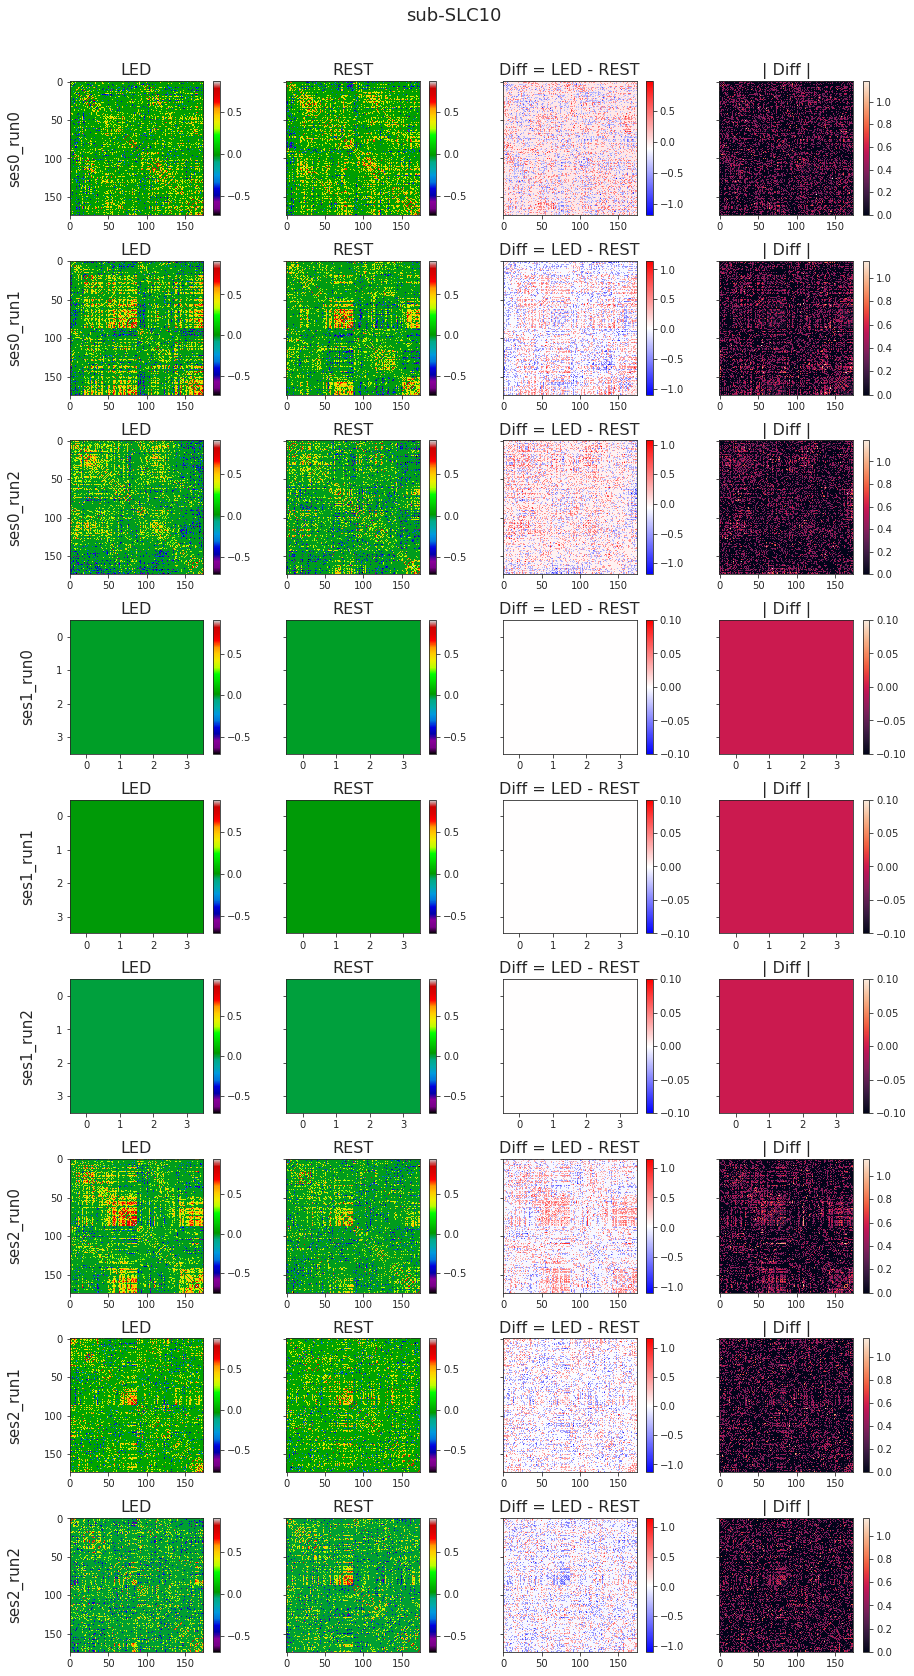

In [13]:
fig, axes = create_figure(9, 4, (13., 23), 'row', 'row')

looper = itertools.product(range(3), range(3))
for i, j in looper:
    vmin = min(np.min(adj_led[anim, i, j]), np.min(adj_rest[anim, i, j]))
    vmax = min(np.max(adj_led[anim, i, j]), np.max(adj_rest[anim, i, j]))

    ax = axes[i * 3 + j, 0]
    x2plt = adj_led[anim, i, j]
    x2plt = x2plt[good_nodes[anim, i, j]][:, good_nodes[anim, i, j]]
    im = ax.imshow(x2plt, vmin=vmin, vmax=vmax, cmap='nipy_spectral')
    plt.colorbar(im, ax=ax)
    ax.set_title('LED', fontsize=16)
    ax.set_ylabel(f"ses{i}_run{j}", fontsize=15, labelpad=20)

    ax = axes[i * 3 + j, 1]
    x2plt = adj_rest[anim, i, j]
    x2plt = x2plt[good_nodes[anim, i, j]][:, good_nodes[anim, i, j]]
    im = ax.imshow(x2plt, vmin=vmin, vmax=vmax, cmap='nipy_spectral')
    plt.colorbar(im, ax=ax)
    ax.set_title('REST', fontsize=16)

    ax = axes[i * 3 + j, 2]
    # vminmax = np.nanmax(np.abs(diff[anim, i, j]))
    # print(i, j, vminmax)
    # vminmax = 0.6
    x2plt = diff[anim, i, j]
    x2plt = x2plt[good_nodes[anim, i, j]][:, good_nodes[anim, i, j]]
    # im = ax.imshow(x2plt, vmin=-vminmax, vmax=vminmax, cmap='bwr')
    im = ax.imshow(x2plt, cmap='bwr')
    plt.colorbar(im, ax=ax)
    ax.set_title('Diff = LED - REST', fontsize=16)

    ax = axes[i * 3 + j, 3]
    x2plt = diff_abs[anim, i, j]
    x2plt = x2plt[good_nodes[anim, i, j]][:, good_nodes[anim, i, j]]
    im = ax.imshow(x2plt, cmap='rocket')
    plt.colorbar(im, ax=ax)
    ax.set_title('| Diff |', fontsize=16)

fig.suptitle(f"{mice.get_key(anim + 1)}", fontsize=18, y=1.01)
plt.show()

In [14]:
top, flat = base.load_top_flat()
top.shape

(1320, 1140)

In [15]:
diff_proj = np_nans((*diff_norm.shape[:3], *top.shape))
looper = itertools.product(*[range(i) for i in data_led.shape[:3]])
for i, j, k in looper:
    x = diff_norm[i, j, k]
    x[~good_nodes[i, j, k]] = np.nan
    proj = base.project_vec(x, thres=min(x), add_disjoint=False)
    diff_proj[i, j, k] = proj['top'][0]

In [16]:
anim = 9

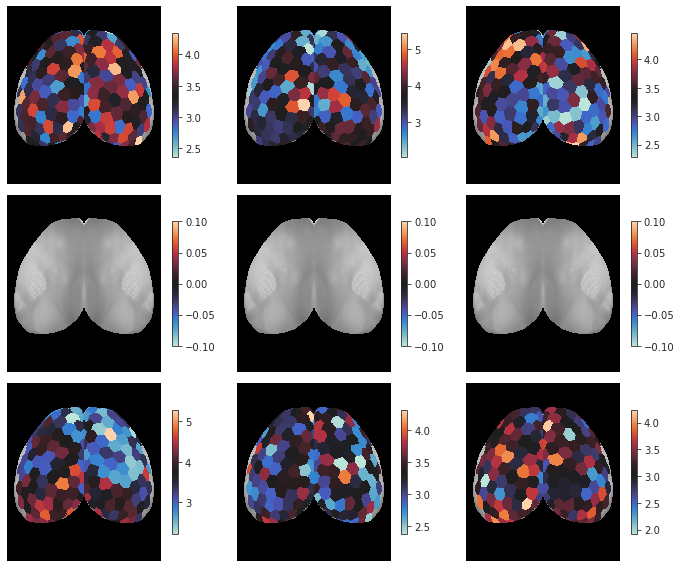

In [17]:
fig, axes = create_figure(3, 3, figsize=(10, 8))
looper = itertools.product(range(3), range(3))
for i, j in looper:
    ax = axes[i, j]
    ax.imshow(top, cmap='Greys_r')
    x2plt = diff_proj[anim, i, j]
    x2plt = np.ma.masked_where(x2plt == 0, x2plt)
    im = ax.imshow(x2plt, cmap='icefire')
    plt.colorbar(im, ax=ax, shrink=0.7)
remove_ticks(axes)

In [47]:
adj_led_anim = bn.nanmean(bn.nanmean(adj_led, 2), 1)
adj_rest_anim = bn.nanmean(bn.nanmean(adj_rest, 2), 1)

In [48]:
d = adj_led_anim - adj_rest_anim
d_norm = np.linalg.norm(d, axis=-1)
d.shape, d_norm.shape

((10, 174, 174), (10, 174))

<matplotlib.colorbar.Colorbar object at 0x7f08f64939d0>

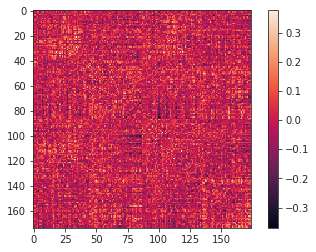

In [49]:
plt.imshow(d[anim])
plt.colorbar()

<matplotlib.image.AxesImage object at 0x7f08f5cfacd0>

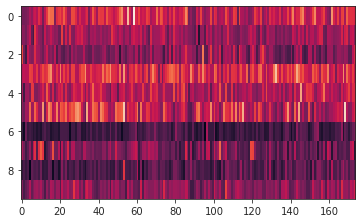

In [50]:
plt.imshow(d_norm, aspect=10)

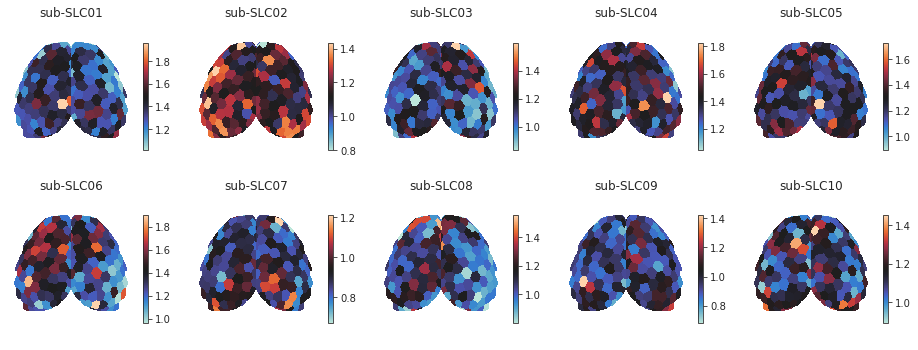

In [51]:
fig, axes = create_figure(2, 5, (13, 5))
for anim, ax in enumerate(axes.flat):
    proj = base.project_vec(d_norm[anim], thres=min(d_norm[anim]), add_disjoint=False)

    x2plt = proj['top'][0]
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    im = ax.imshow(x2plt, cmap='icefire')
    plt.colorbar(im, ax=ax, shrink=0.7)
    ax.set_title(mice.get_key(anim + 1))

remove_ticks(axes)
plt.show()

In [52]:
data_led.shape

(10, 3, 3, 174, 40)

In [53]:
cat_led = np.transpose(data_led, (0, 3, 4, 1, 2))
cat_led = cat_led.reshape((*cat_led.shape[:2], -1))

cat_rest = np.transpose(data_rest, (0, 3, 4, 1, 2))
cat_rest = cat_rest.reshape((*cat_rest.shape[:2], -1))

cat_led.shape, cat_rest.shape

((10, 174, 360), (10, 174, 360))

In [54]:
anim = 9
a_led, _ = get_adj_mat(cat_led[anim], 'pearson')
a_rest, _ = get_adj_mat(cat_rest[anim], 'pearson')
d = a_led - a_rest

_good = np.abs(a_led).sum(0) > 0

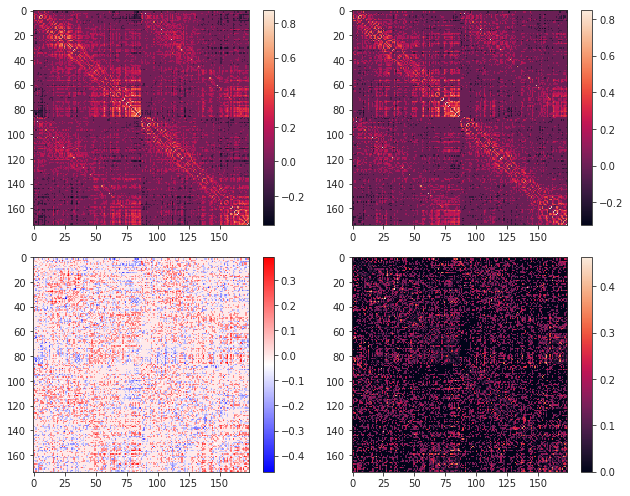

In [55]:
fig, axes = create_figure(2, 2, (9, 7))
im = axes[0, 0].imshow(a_led[_good][:, _good])
plt.colorbar(im, ax=axes[0, 0])
im = axes[0, 1].imshow(a_rest[_good][:, _good])
plt.colorbar(im, ax=axes[0, 1])
im = axes[1, 0].imshow(d[_good][:, _good], cmap='bwr')
plt.colorbar(im, ax=axes[1, 0])
im = axes[1, 1].imshow(np.abs(d)[_good][:, _good])
plt.colorbar(im, ax=axes[1, 1])
plt.show()

In [60]:
d_norm = np.zeros(len(base.n2l))
# d_norm[_good] = np.max(np.abs(d[_good][:, _good]), axis=0)
d_norm[_good] = np.linalg.norm(d[_good][:, _good], ord=1, axis=0)

<matplotlib.colorbar.Colorbar object at 0x7f08f658a0a0>

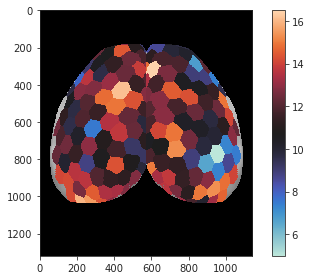

In [61]:
proj = base.project_vec(d_norm, thres=min(d_norm), add_disjoint=False)

fig, ax = create_figure()
ax.imshow(top, cmap='Greys_r')

x2plt = proj['top'][0]
x2plt = np.ma.masked_where(x2plt == 0, x2plt)
# x2plt = np.ma.masked_where(~np.logical_and(0.86 < x2plt, x2plt < 5), x2plt)
plt.imshow(x2plt ,cmap='icefire')
plt.colorbar()

In [62]:
anim = 1

a_led, _ = get_adj_mat(cat_led[anim], 'pearson')
a_rest, _ = get_adj_mat(cat_rest[anim], 'pearson')
d = a_led - a_rest

_good = np.abs(a_led).sum(0) > 0

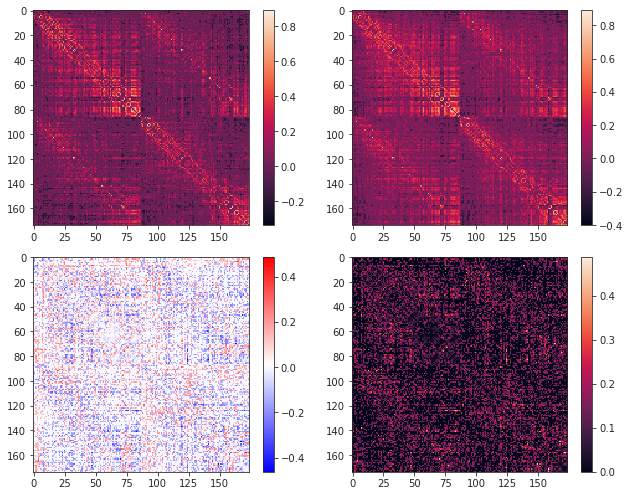

In [63]:
fig, axes = create_figure(2, 2, (9, 7))
im = axes[0, 0].imshow(a_led[_good][:, _good])
plt.colorbar(im, ax=axes[0, 0])
im = axes[0, 1].imshow(a_rest[_good][:, _good])
plt.colorbar(im, ax=axes[0, 1])
im = axes[1, 0].imshow(d[_good][:, _good], cmap='bwr')
plt.colorbar(im, ax=axes[1, 0])
im = axes[1, 1].imshow(np.abs(d)[_good][:, _good])
plt.colorbar(im, ax=axes[1, 1])
plt.show()

In [64]:
d_norm = np.zeros(len(base.n2l))
d_norm[_good] = np.max(np.abs(d[_good][:, _good]), axis=0)
# d_norm[_good] = np.linalg.norm(d[_good][:, _good], ord=1, axis=0)

<matplotlib.colorbar.Colorbar object at 0x7f08f701dc40>

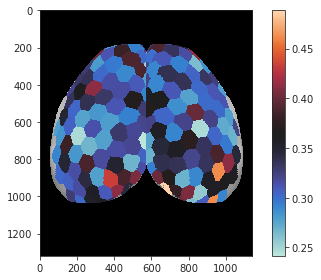

In [65]:
proj = base.project_vec(d_norm, thres=min(d_norm), add_disjoint=False)

fig, ax = create_figure()
ax.imshow(top, cmap='Greys_r')

x2plt = proj['top'][0]
x2plt = np.ma.masked_where(x2plt == 0, x2plt)
# x2plt = np.ma.masked_where(~np.logical_and(0.1 < x2plt, x2plt < 0.4), x2plt)
plt.imshow(x2plt ,cmap='icefire')
plt.colorbar()

## GLM

In [18]:
from sklearn import linear_model
ner = Normalizer()

In [19]:
data_all = np.concatenate([data_led, data_rest], -1)
y = [1] * data_led.shape[-1] + [0] * data_led.shape[-1]
y = np.array(y)

data_all.shape, y.shape

((10, 3, 3, 174, 80), (80,))

In [20]:
x.shape

(7, 174, 40)

In [21]:
x.shape

(7, 174, 40)

In [22]:
coef_glm = np.zeros(data_all.shape[:4])
coef_logreg = np.zeros(data_all.shape[:4])
looper = itertools.product(*[range(i) for i in data_all.shape[:3]])
for i, j, k in looper:
    if not good_nodes[i, j, k].sum():
        continue

    x = data_all[i, j, k][good_nodes[i, j, k]].T
    nan_time = np.isnan(x).sum(1) > 0
    if nan_time.sum() > 70:
        print(i, j, k, '. . . ', nan_time.sum())
        continue
    
    glm = linear_model.PoissonRegressor(
        alpha=1000,
        max_iter=int(1e5),
    ).fit(x[~nan_time], y[~nan_time])
    logreg = linear_model.LogisticRegression(
        C=0.001,
        penalty='l2',
        solver='lbfgs',
    ).fit(x[~nan_time], y[~nan_time])

    c_glm = np.zeros(len(base.n2l))
    c_glm[good_nodes[i, j, k]] = glm.coef_
    c_glm = ner.fit_transform(c_glm.reshape(1, -1))
    c_glm = c_glm.ravel()
    if max(c_glm, key=abs) < 0:
        c_glm *= -1
    coef_glm[i, j, k] = c_glm.ravel()

    c_logreg = np.zeros(len(base.n2l))
    c_logreg[good_nodes[i, j, k]] = logreg.coef_.ravel()
    c_logreg = ner.fit_transform(c_logreg.reshape(1, -1))
    c_logreg = c_logreg.ravel()
    if max(c_logreg, key=abs) < 0:
        c_logreg *= -1
    coef_logreg[i, j, k] = c_logreg

1 0 0 . . .  80

1 0 1 . . .  80

1 0 2 . . .  80

2 0 0 . . .  80

2 0 1 . . .  80

2 0 2 . . .  80

4 0 0 . . .  80

4 0 1 . . .  80

4 0 2 . . .  80

5 2 0 . . .  80

6 0 2 . . .  80

6 2 0 . . .  80

6 2 1 . . .  80

6 2 2 . . .  80

7 2 0 . . .  80

7 2 1 . . .  80

7 2 2 . . .  80

8 2 0 . . .  80

8 2 1 . . .  80

8 2 2 . . .  80

9 1 0 . . .  80

9 1 1 . . .  80

9 1 2 . . .  80

In [26]:
top, flat = base.load_top_flat()
anim = 9

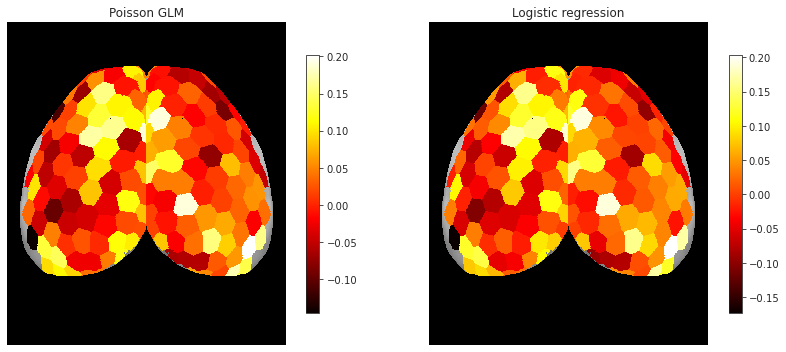

In [27]:
fig, axes = create_figure(1, 2, (12, 5))

c_glm = coef_glm[anim, 0, 1]
c_logreg = coef_logreg[anim, 0, 1]

proj = base.project_vec(c_glm, thres=min(c_glm), add_disjoint=False)
x2plt = proj['top'][0]
x2plt = np.ma.masked_where(x2plt == 0, x2plt)
axes[0].imshow(top, cmap='Greys_r')
im = axes[0].imshow(x2plt, cmap='hot')
plt.colorbar(im, ax=axes[0], shrink=0.8)
axes[0].set_title('Poisson GLM')

proj = base.project_vec(c_logreg, thres=min(c_logreg), add_disjoint=False)
x2plt = proj['top'][0]
x2plt = np.ma.masked_where(x2plt == 0, x2plt)
axes[1].imshow(top, cmap='Greys_r')
im = axes[1].imshow(x2plt, cmap='hot')
plt.colorbar(im, ax=axes[1], shrink=0.8)
axes[1].set_title('Logistic regression')

remove_ticks(axes)

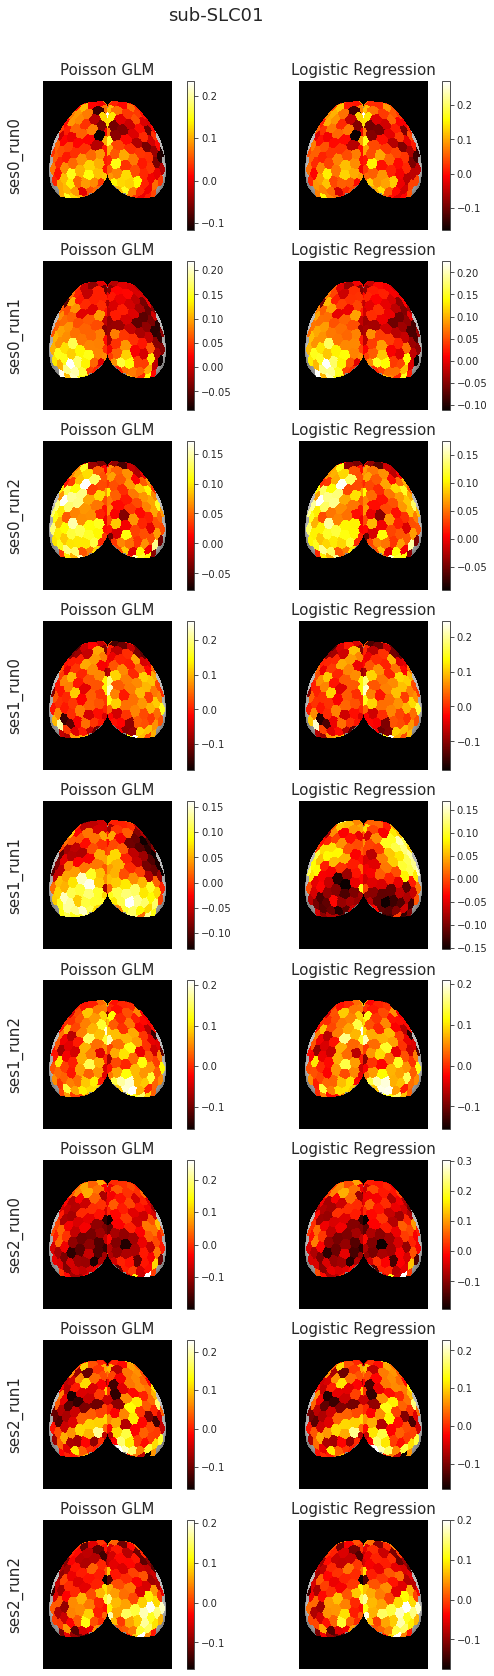

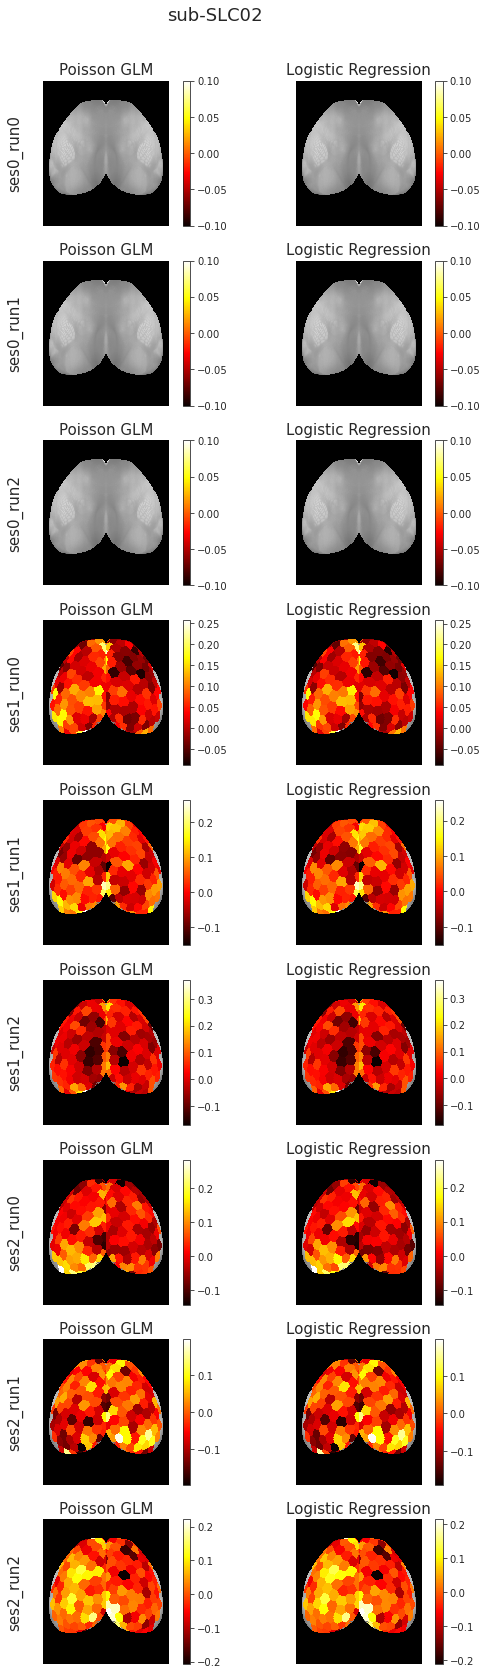

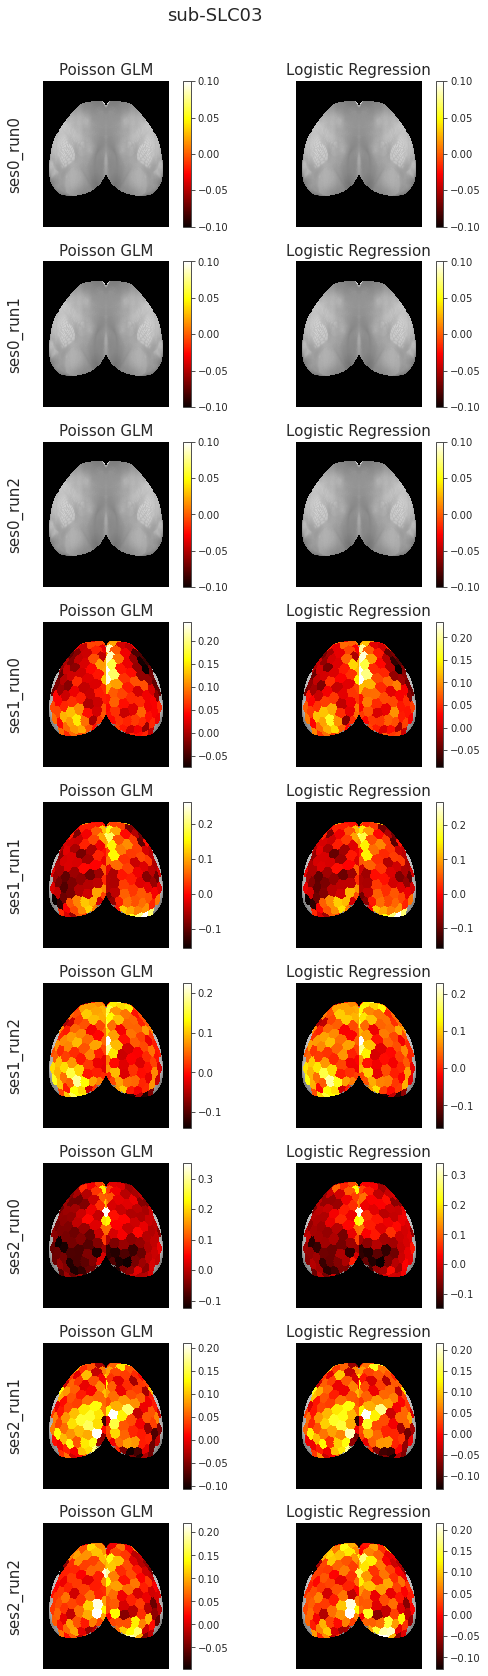

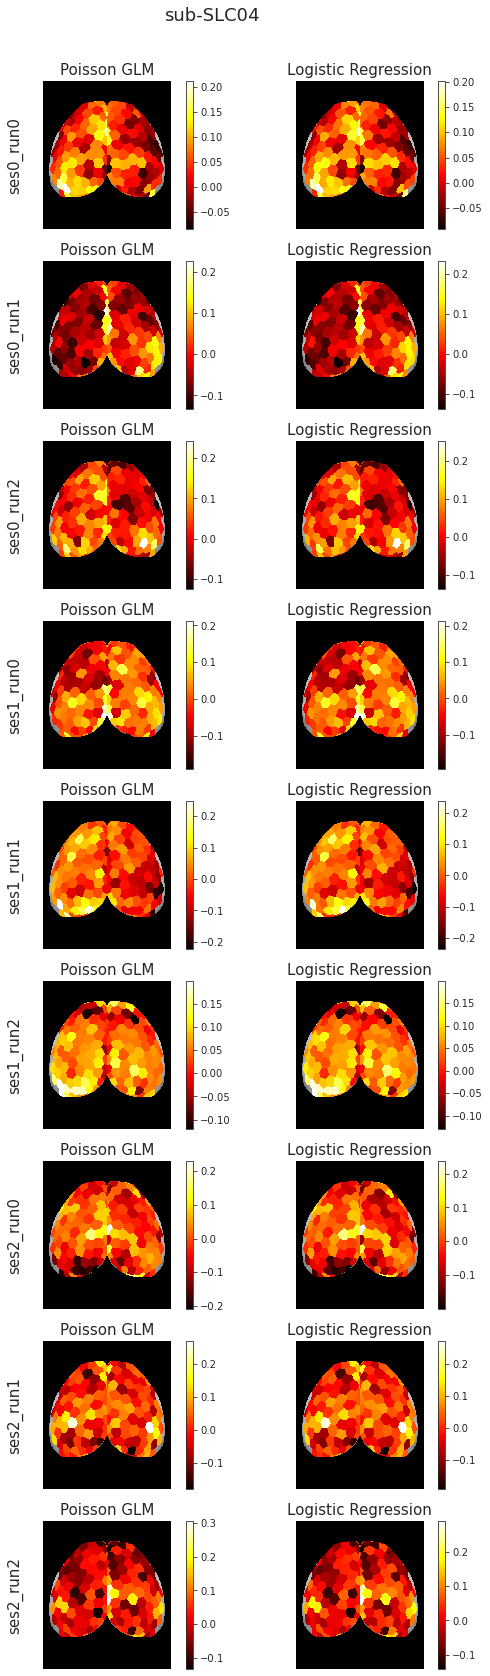

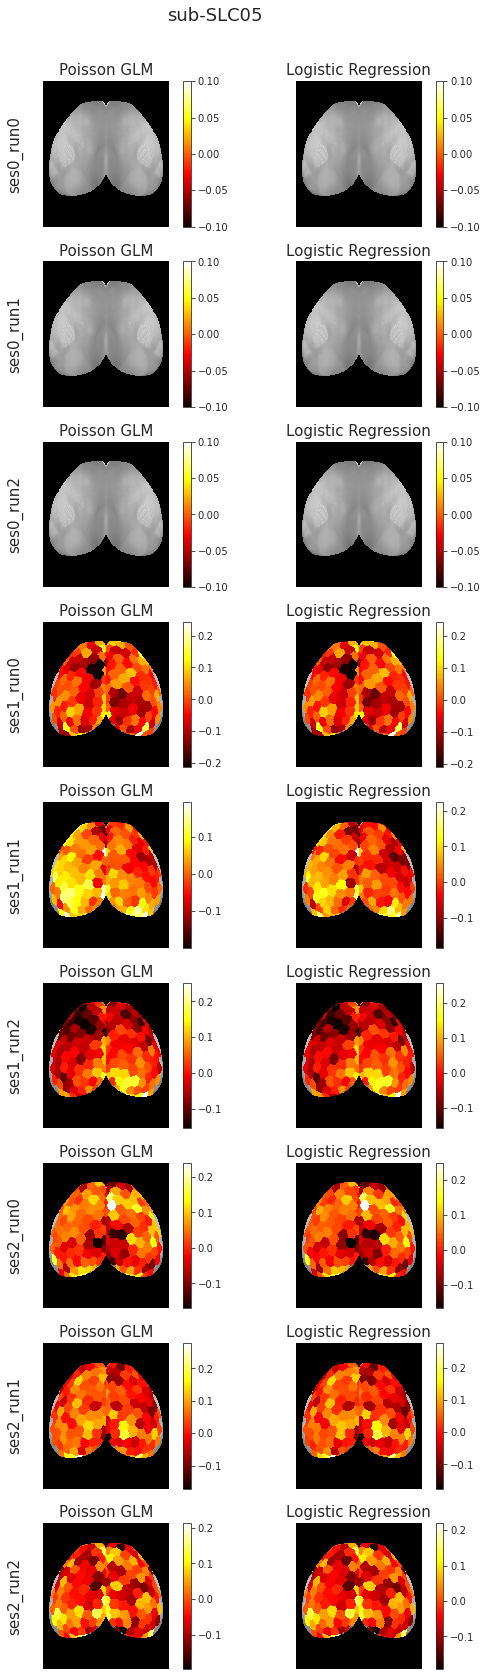

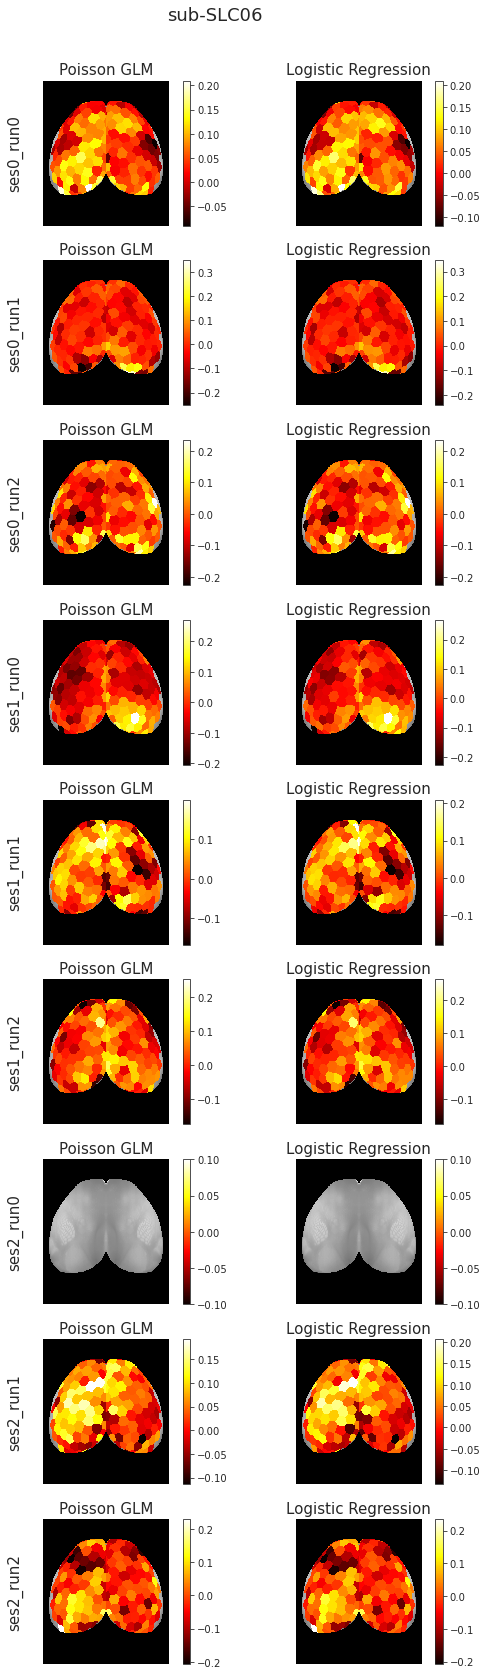

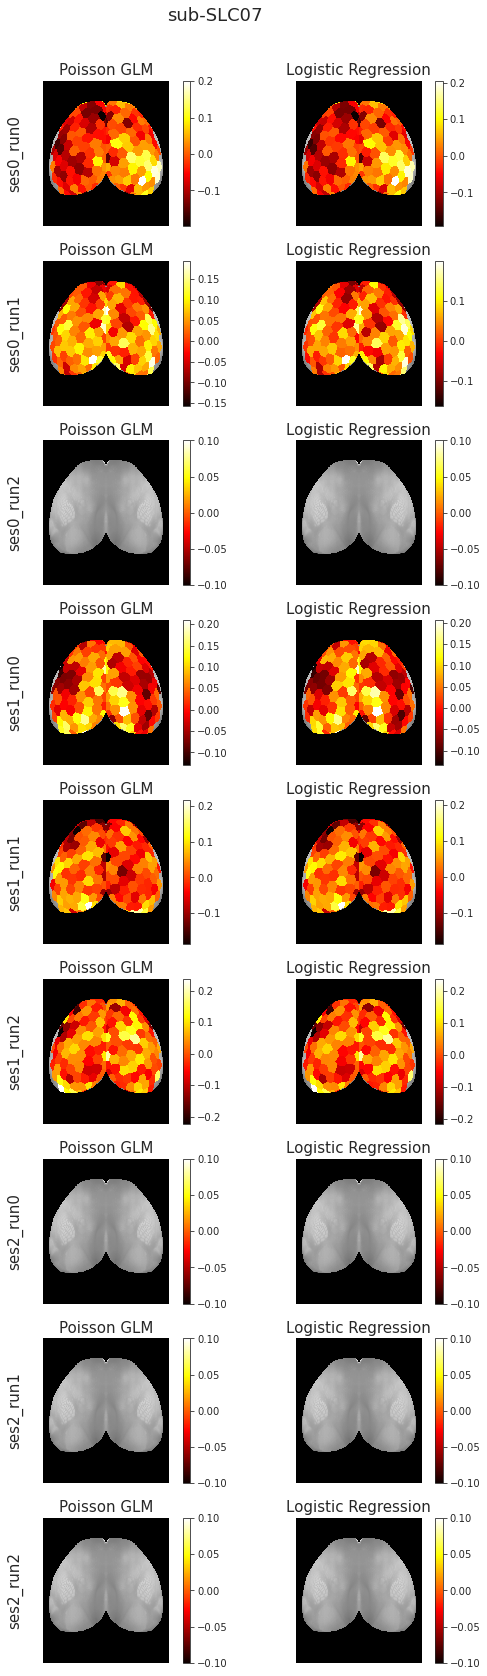

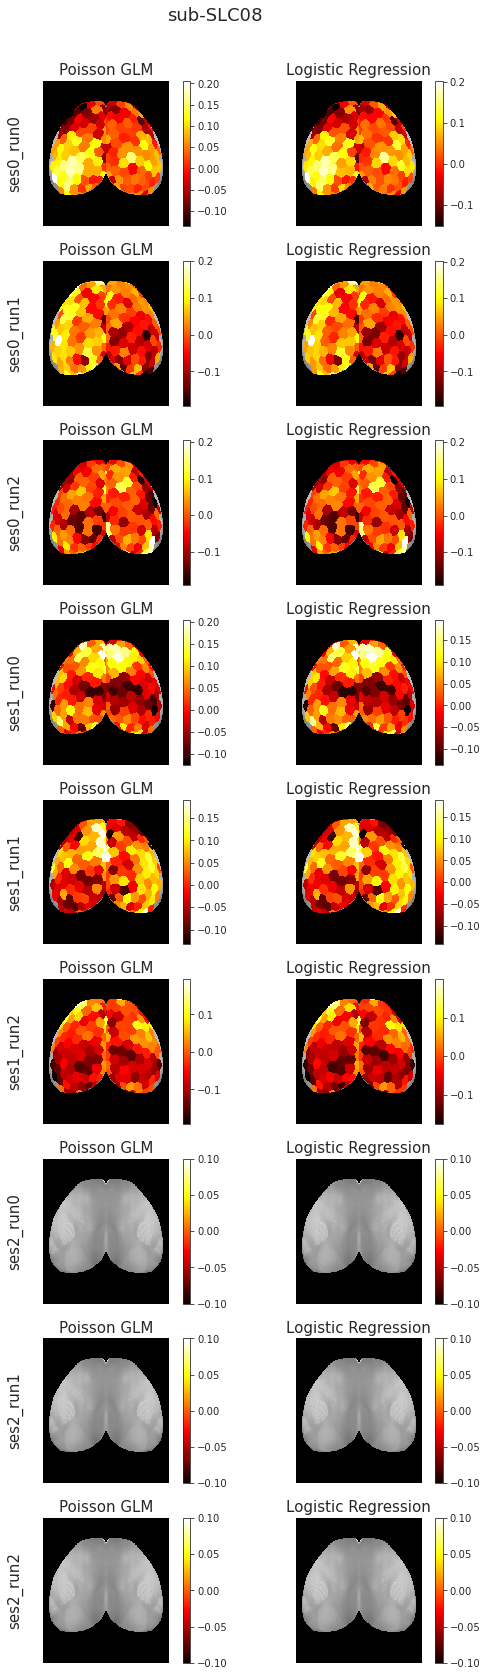

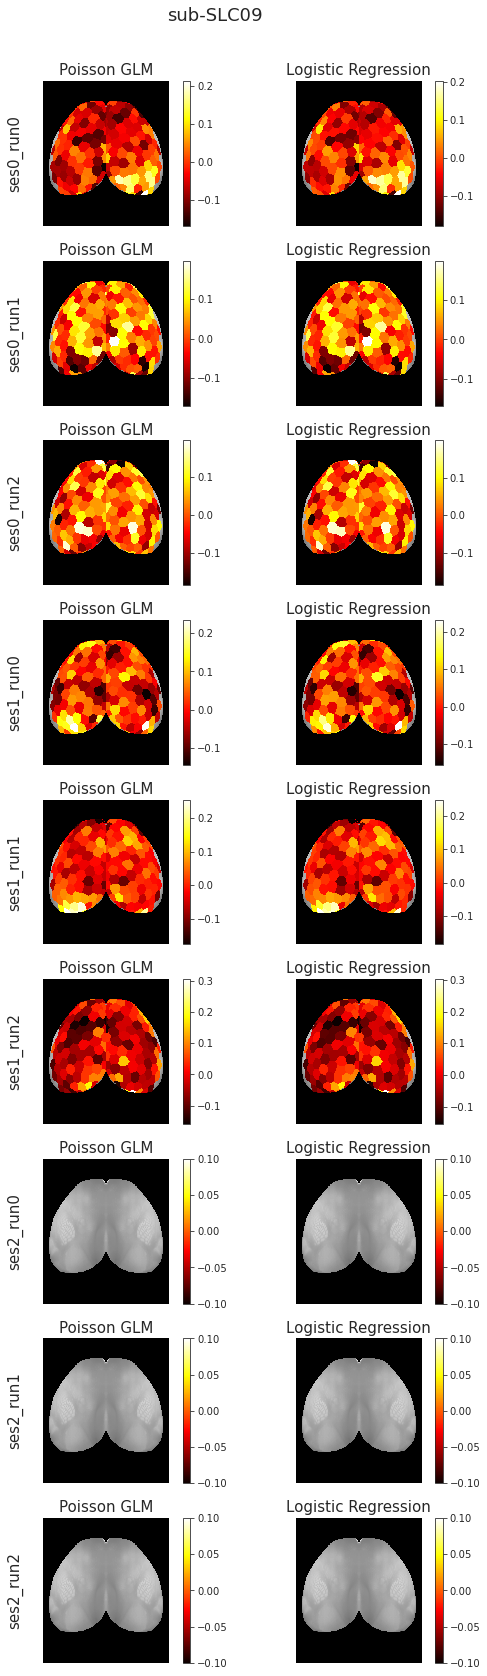

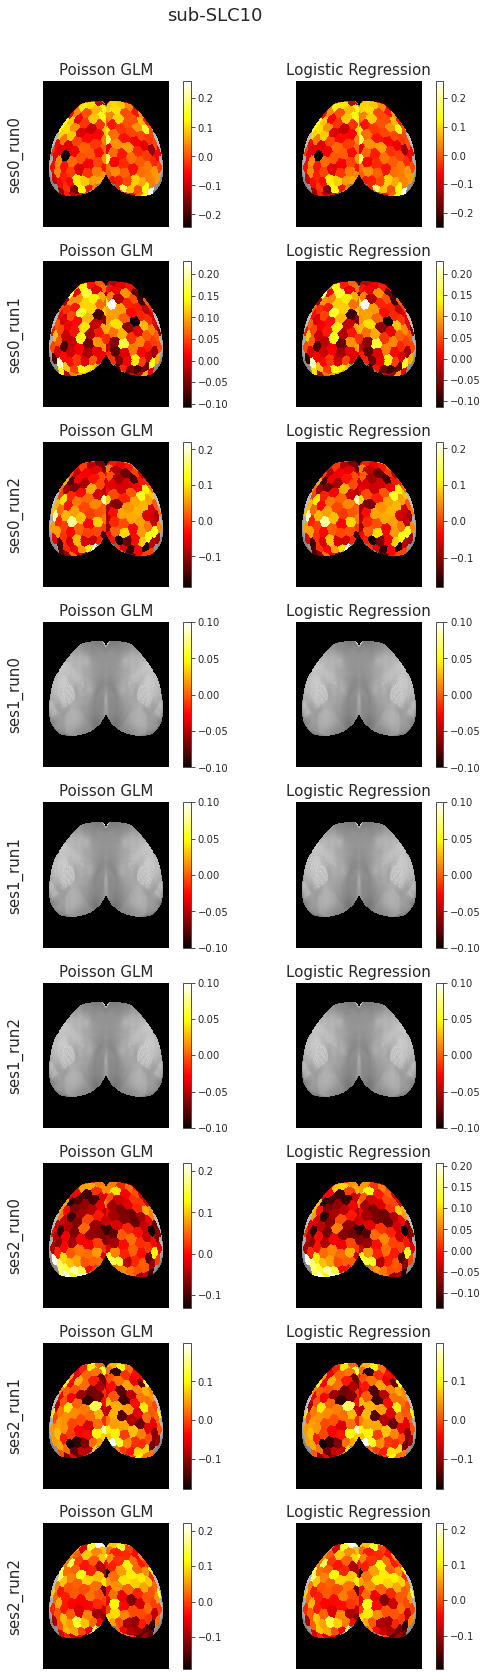

In [89]:
for anim in range(10):
    fig, axes = create_figure(9, 2, (8., 23))

    looper = itertools.product(range(3), range(3))
    for i, j in looper:
        c_glm = coef_glm[anim, i, j]
        c_logreg = coef_logreg[anim, i, j]

        ax = axes[i * 3 + j, 0]
        proj = base.project_vec(c_glm, thres=min(c_glm), add_disjoint=False)
        x2plt = proj['top'][0]
        x2plt = np.ma.masked_where(x2plt == 0, x2plt)
        ax.imshow(top, cmap='Greys_r')
        im = ax.imshow(x2plt, cmap='hot')
        plt.colorbar(im, ax=ax)
        ax.set_title('Poisson GLM', fontsize=15)
        ax.set_ylabel(f"ses{i}_run{j}", fontsize=15, labelpad=20)

        ax = axes[i * 3 + j, 1]
        proj = base.project_vec(c_logreg, thres=min(c_logreg), add_disjoint=False)
        x2plt = proj['top'][0]
        x2plt = np.ma.masked_where(x2plt == 0, x2plt)
        ax.imshow(top, cmap='Greys_r')
        im = ax.imshow(x2plt, cmap='hot')
        plt.colorbar(im, ax=ax)
        ax.set_title('Logistic Regression', fontsize=15)
    remove_ticks(axes)
    fig.suptitle(f"{mice.get_key(anim + 1)}", fontsize=18, y=1.01)
    plt.show()

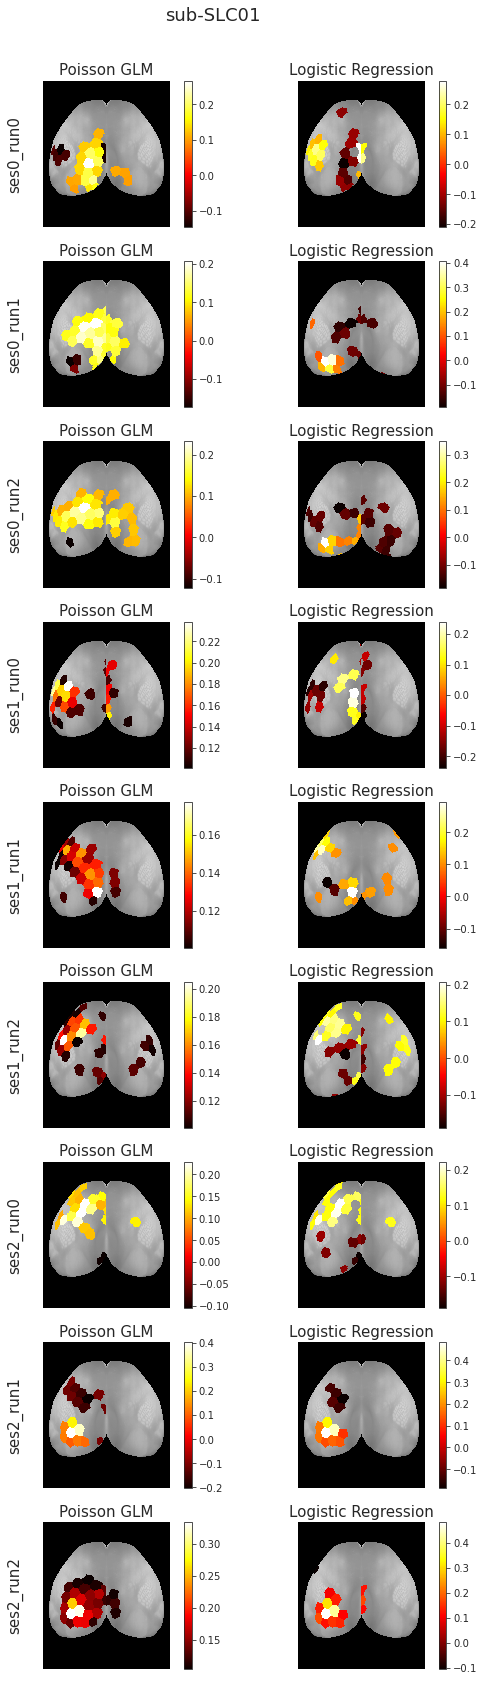

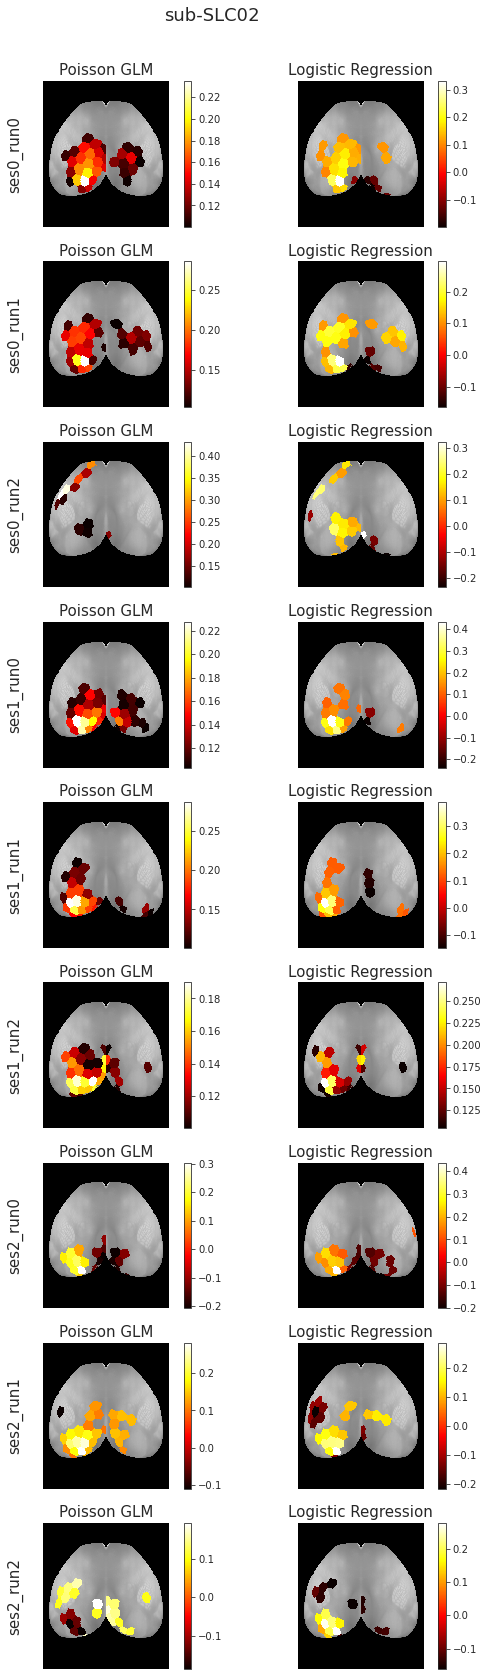

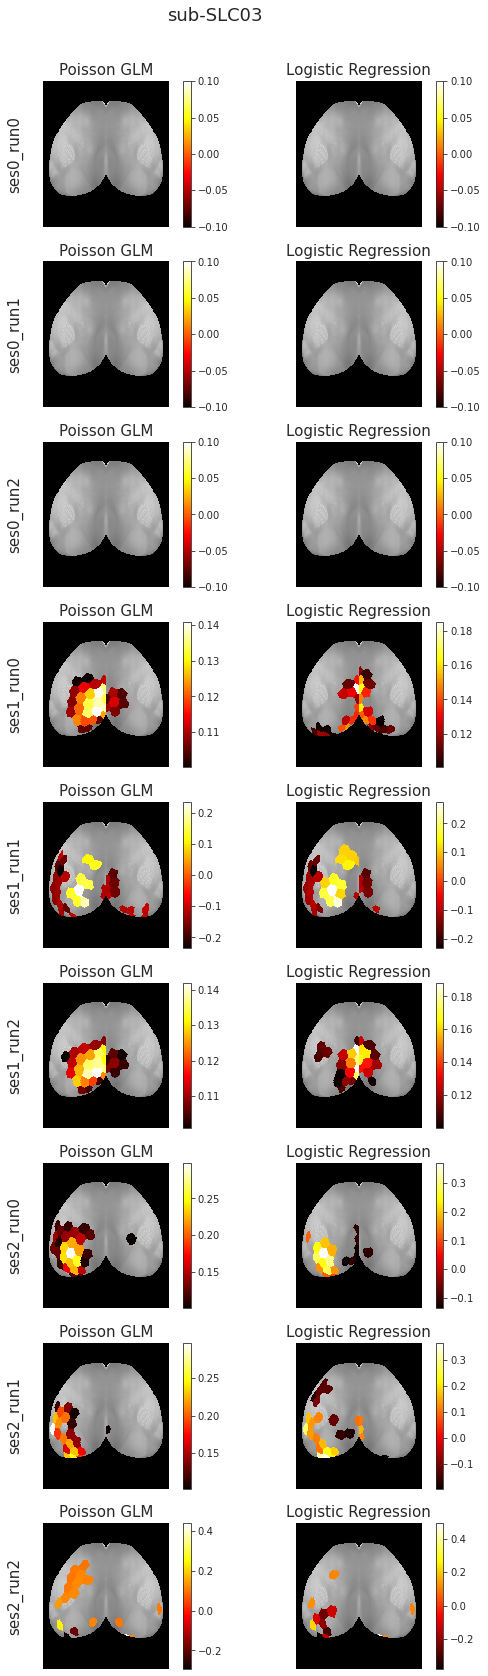

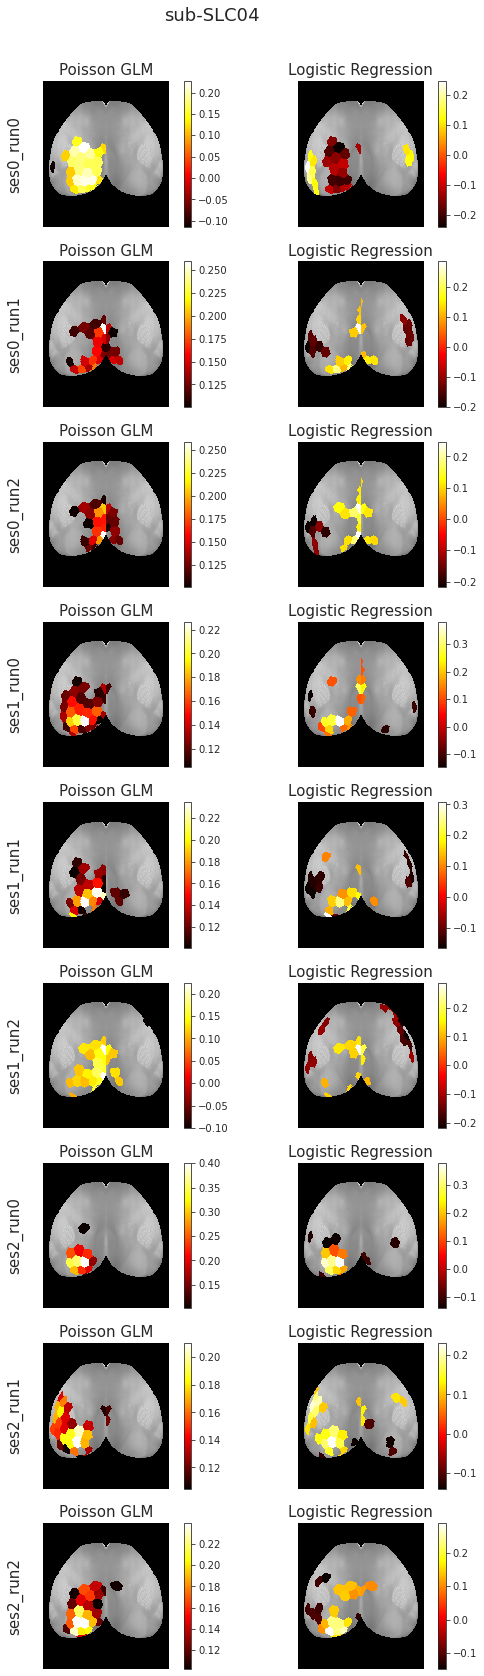

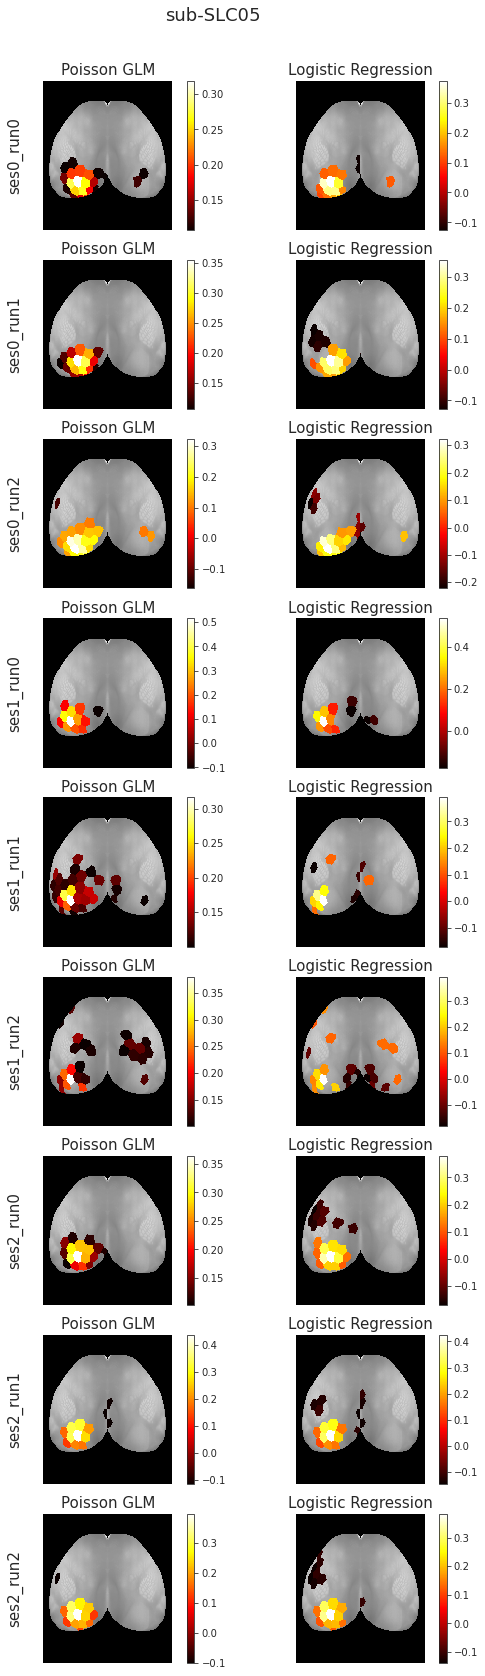

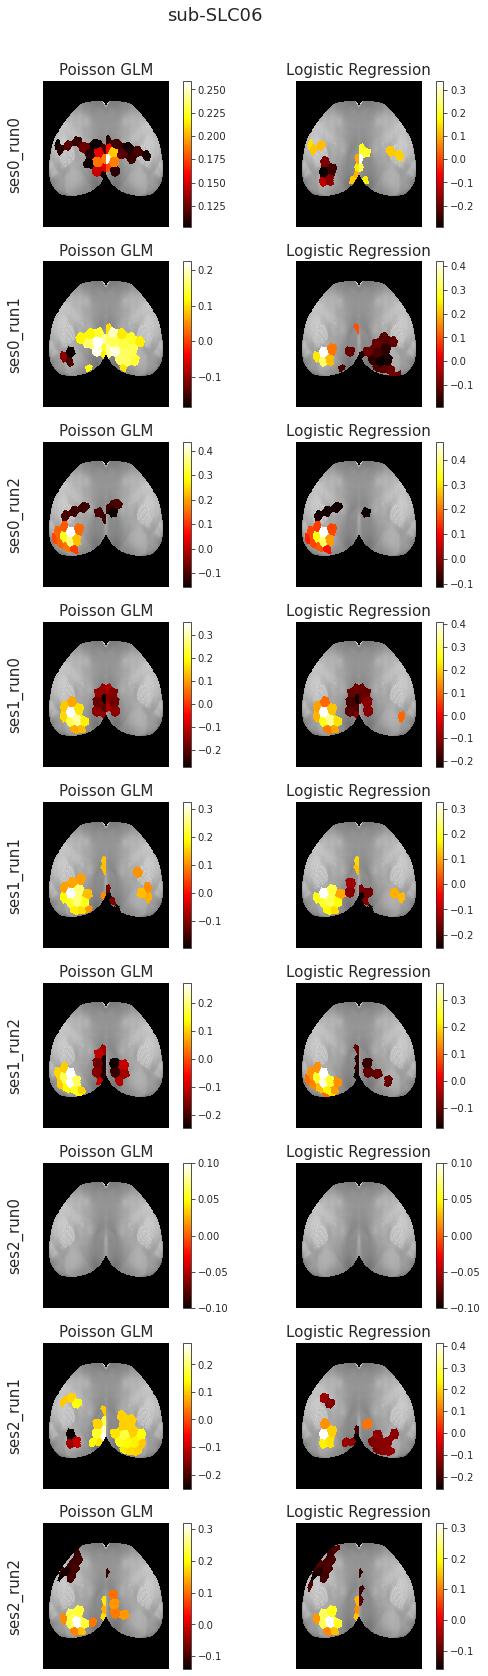

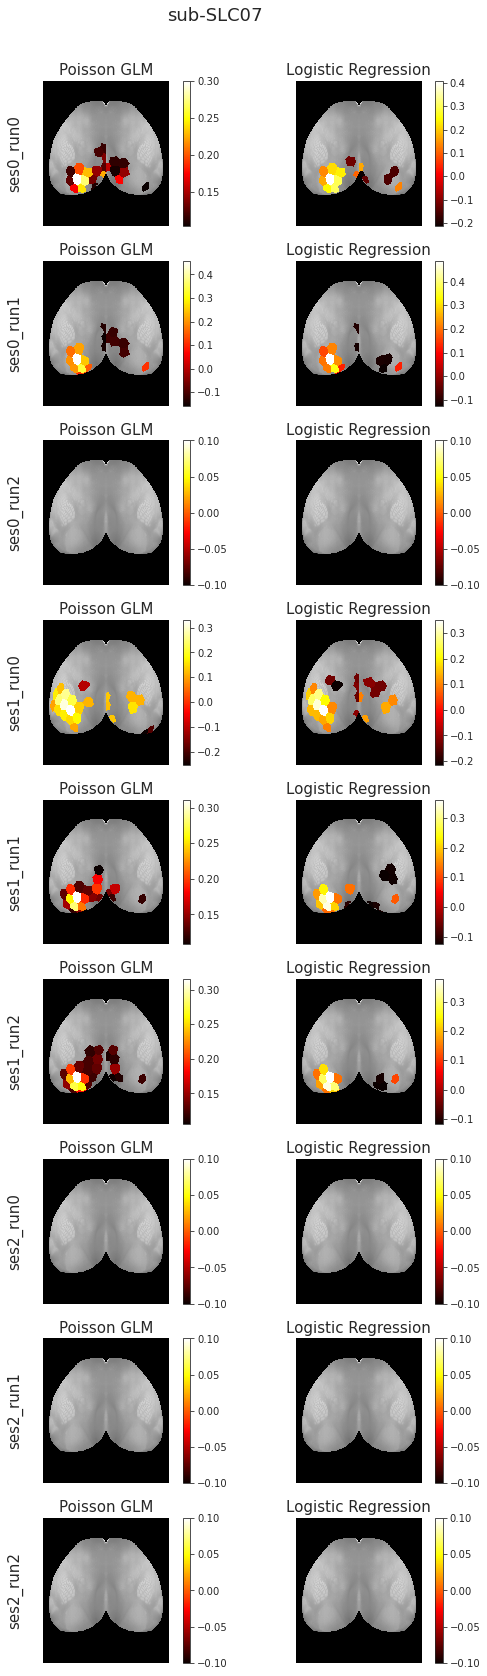

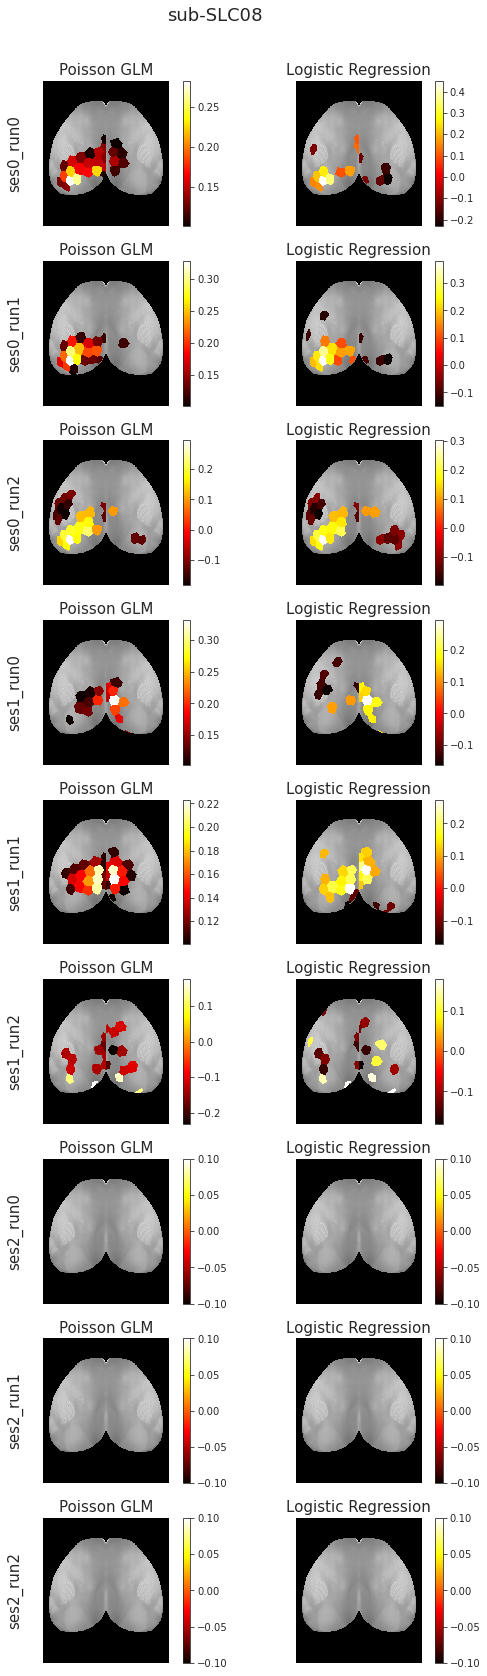

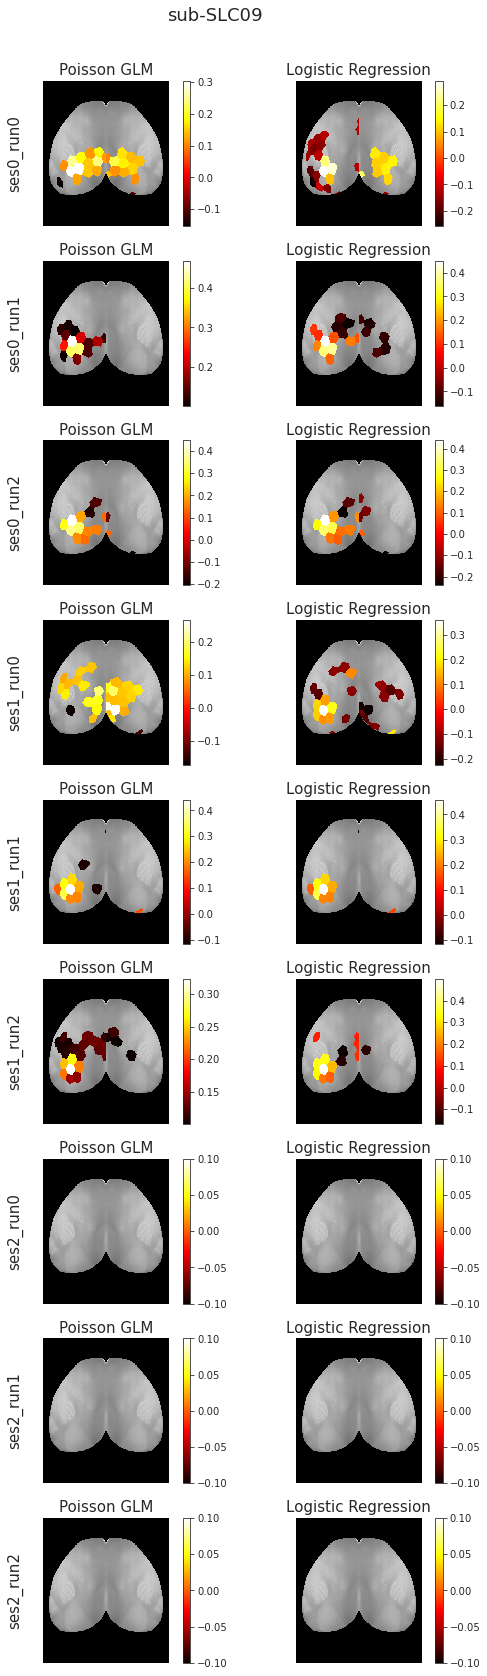

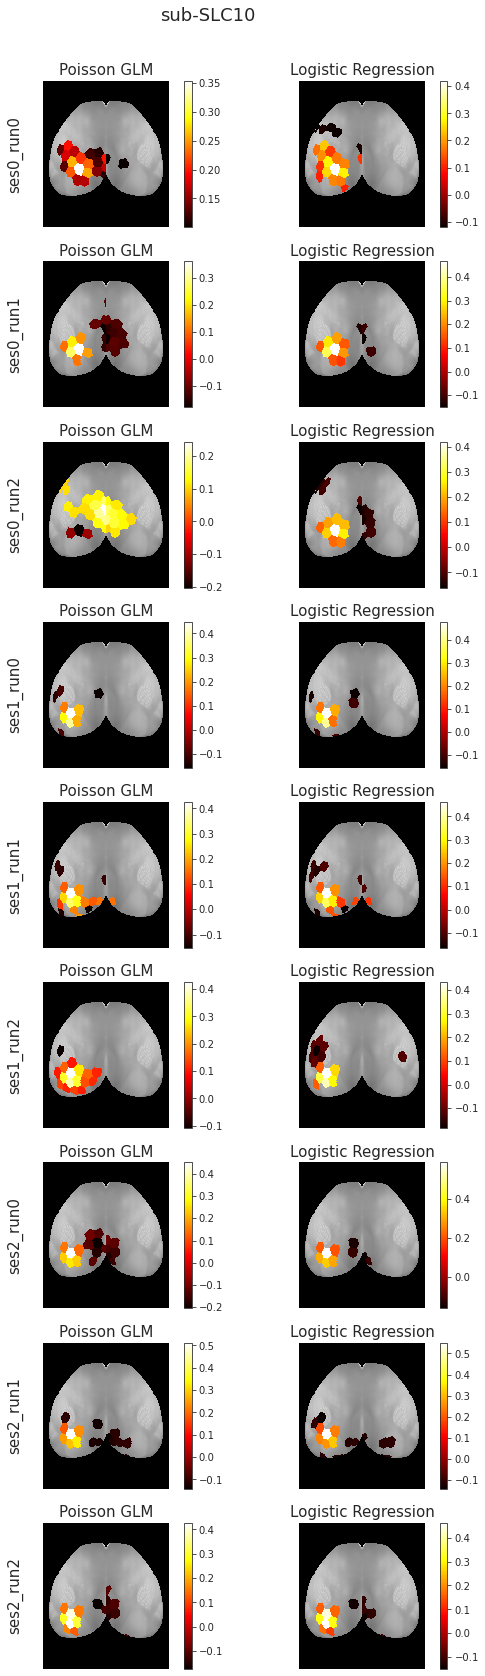

In [263]:
for anim in range(10):
    fig, axes = create_figure(9, 2, (8., 23))

    looper = itertools.product(range(3), range(3))
    for i, j in looper:
        c_glm = coef_glm[anim, i, j]
        c_logreg = coef_logreg[anim, i, j]

        ax = axes[i * 3 + j, 0]
        proj = base.project_vec(c_glm, thres=min(c_glm), add_disjoint=False)
        x2plt = proj['top'][0]
        x2plt = np.ma.masked_where(np.logical_and(-0.1 < x2plt, x2plt < 0.1), x2plt)
        ax.imshow(top, cmap='Greys_r')
        im = ax.imshow(x2plt, cmap='hot')
        plt.colorbar(im, ax=ax)
        ax.set_title('Poisson GLM', fontsize=15)
        ax.set_ylabel(f"ses{i}_run{j}", fontsize=15, labelpad=20)

        ax = axes[i * 3 + j, 1]
        proj = base.project_vec(c_logreg, thres=min(c_logreg), add_disjoint=False)
        x2plt = proj['top'][0]
        x2plt = np.ma.masked_where(np.logical_and(-0.1 < x2plt, x2plt < 0.1), x2plt)
        ax.imshow(top, cmap='Greys_r')
        im = ax.imshow(x2plt, cmap='hot')
        plt.colorbar(im, ax=ax)
        ax.set_title('Logistic Regression', fontsize=15)
    remove_ticks(axes)
    fig.suptitle(f"{mice.get_key(anim + 1)}", fontsize=18, y=1.01)
    plt.show()